CS524: Introduction to Optimization Lecture 27
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## November 6, 2023
--------------

# Hovercraft example

We are in command of a hovercraft. We are given a set of $k$ waypoint locations and times. The objective is to hit the waypoints at the prescribed times while minimizing fuel use.  Example of discrete time dynamics.

* Discretize time: $t = 0,1,2,...,T$.
* Important variables: position $x_t$, velocity $v_t$, thrust $u_t$. 
* Simplified model of the dynamics:
  * $x_{t+1} =x_t + v_t$, for $t = 0, 1, . . . , T − 1$
  * $v_{t+1} =v_t +u_t$, for $t = 0, 1, . . . , T − 1$
* We must choose $u_0,u_1,...,u_{T-1}$.
* Initial position and velocity: $x_0 = 0$ and $v_0 = 0$. 
* Waypoint constraints: $x_{t_i} = w_i$ for $i = 1,...,k$. 
* Minimize fuel use: $$\left\Vert u_0 \right\Vert^2 + \left\Vert u_1\right\Vert^2 +\cdots+\left\Vert u_{T-1}\right\Vert^2$$

First model: hit all the waypoints exactly: compute solution
\begin{align*}
\min_{x_t,v_t,u_t} & \sum_{t=0}^{T-1} \left\Vert u_t \right\Vert^2 \\ 
\text{subject to } & x_{t+1} = x_t + v_t & \text{for $t=0,1,\ldots,T-1$}\\
& v_{t+1} = v_t + u_t & \text{for $t=0,1,\ldots,T-1$}\\
& x_0 = v_0 = 0 \\
& x_{t_i} = w_i & \text{for $i=1,\ldots,k$}
\end{align*}

Set up gams magic.
Then generate data and share it with the gams environment.

In [1]:
%load_ext gams.magic
m = gams.exchange_container
import pandas as pd
import numpy as np

T = [0, 20, 50, 60]
t = m.addSet('t', records=range(0,max(T)+1))
c = m.addSet('c', description='coordinates',records=['x', 'y'])
k = m.addSet('k', description='number of waypoints',records=range(1,5))
w = m.addParameter('w',[c,k],description='vector of waypoint locations',records=np.array([[1,4,6,1],[1,3,0,1]]))
wtPts = w.pivot()
display(wtPts)
tp = m.addSet('tp',[k,t],description='timepoints',records=[(str(x[0]),str(x[1])) for x in zip(range(1,5),T)])
xvar = m.addVariable('x','free',[c,t],description='resulting position')

,1,2,3,4
x,1.0,4.0,6.0,1.0
y,1.0,3.0,0.0,1.0


In [2]:
%%gams
scalar lamTO tradeoff parameter /0/;

variables
  v(c,t) resulting velocity,
  u(c,t) thruster input,
  obj;

equations dyn1(c,t), dyn2(c,t), defobj;

* simplified dynamics
dyn1(c,t)$(t.ord lt card(t))..
  x(c,t+1) =e= x(c,t) + v(c,t);

dyn2(c,t)$(t.ord lt card(t))..
  v(c,t+1) =e= v(c,t) + u(c,t);

* minimize 2-norm (THIS IS LEAST-SQUARES)
defobj..
  obj =e= sum(t$(t.ord lt card(t)), sum(c, sqr(u(c,t))))
  + lamTO*sum(k$(k.ord gt 1), sum(t$tp(k,t), sum(c, sqr(x(c,t) - w(c,k)))));
  
model m /all/;

* satisfy the dynamics (with zero initial velocity)
v.fx(c,'0') = 0;

* hit all the waypoints
loop(k,
  x.fx(c,t)$tp(k,t) = w(c,k);
);

solve m using qcp minimizing obj;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0408,241,365,QCP,CONOPT,0.013


objective=0.040771


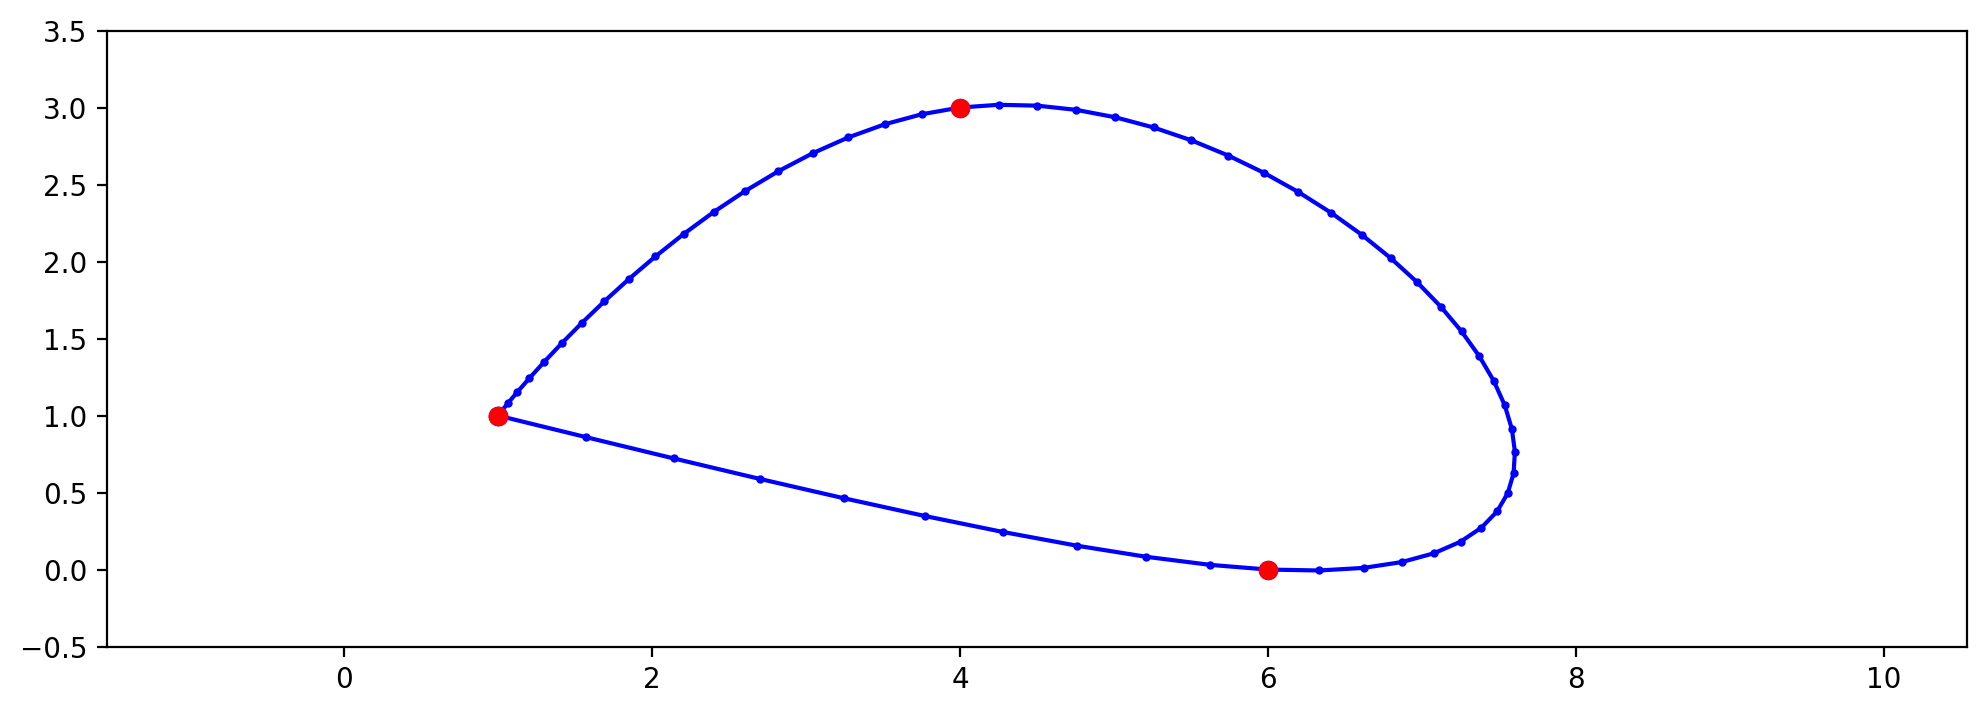

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

obj = m['obj'].toValue()
print(f'objective={obj:f}')
x = xvar.pivot().T
#display(x)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot( x['x'], x['y'], "b.-", markersize=4 )
ax.plot( x['x'][T], x['y'][T], "b.", markersize=12 )
ax.plot( wtPts.loc['x'], wtPts.loc['y'], "r.", markersize=12 )
ax.axis("equal")
ax.axis((1.,8.,-.5,3.5));

Second model: allow waypoint misses

\begin{align*}
\min_{x_t,v_t,u_t} & \sum_{t=0}^{T-1} \left\Vert u_t \right\Vert^2 + \lambda \sum_{i=1}^k \left\Vert x_{t_i} - w_i \right\Vert^2 \\ 
\text{subject to } & x_{t+1} = x_t + v_t & \text{for $t=0,1,\ldots,T-1$}\\
& v_{t+1} = v_t + u_t & \text{for $t=0,1,\ldots,T-1$}\\
& x_0 = v_0 = 0 
\end{align*}

$\lambda$ controls the tradeoff between making $u$ small and hitting all the waypoints.

In [4]:
%%gams
scalar model_status /1/;
scalar J1, J2;

* now release the bounds and penalize errors
x.lo(c,t)$tp('2',t) = -inf; x.up(c,t)$tp('2',t) = inf;
x.lo(c,t)$tp('3',t) = -inf; x.up(c,t)$tp('3',t) = inf;
x.lo(c,t)$tp('4',t) = -inf; x.up(c,t)$tp('4',t) = inf;

lamTO = 0.01;

In [5]:
runit = '''display lamTO;
solve m using qcp minimizing obj;
J1 = sum(t, sum(c, sqr(u.l(c,t))));
J2 = sum(k$(k.ord gt 1), sum(t$tp(k,t), sum(c, sqr(x.l(c,t) - w(c,k)))));
model_status =  m.modelstat;
'''
gams.gams(runit)

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0333,241,365,QCP,CONOPT,0.014


J1=0.027582 J2=0.574086


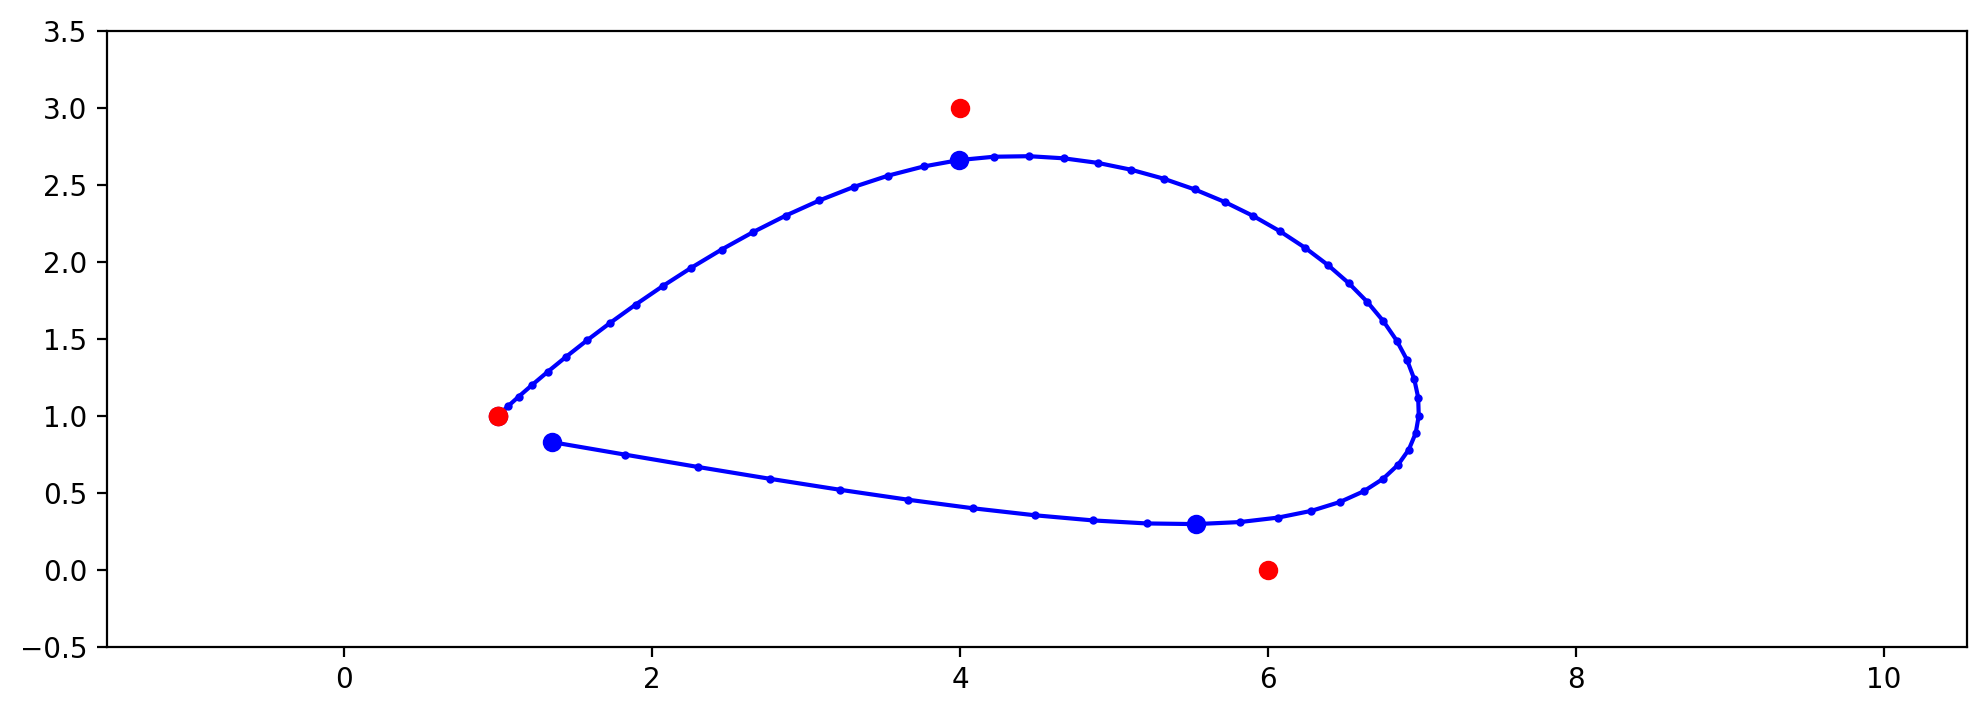

In [6]:
J1=m['J1'].toValue()
J2=m['J2'].toValue()
print(f'J1={J1:f} J2={J2:f}')
x = xvar.pivot().T
#display(x)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot( x['x'], x['y'], "b.-", markersize=4 )
ax.plot( x['x'][T], x['y'][T], "b.", markersize=12 )
ax.plot( wtPts.loc['x'], wtPts.loc['y'], "r.", markersize=12 )
ax.axis("equal")
ax.axis((1.,8.,-.5,3.5));

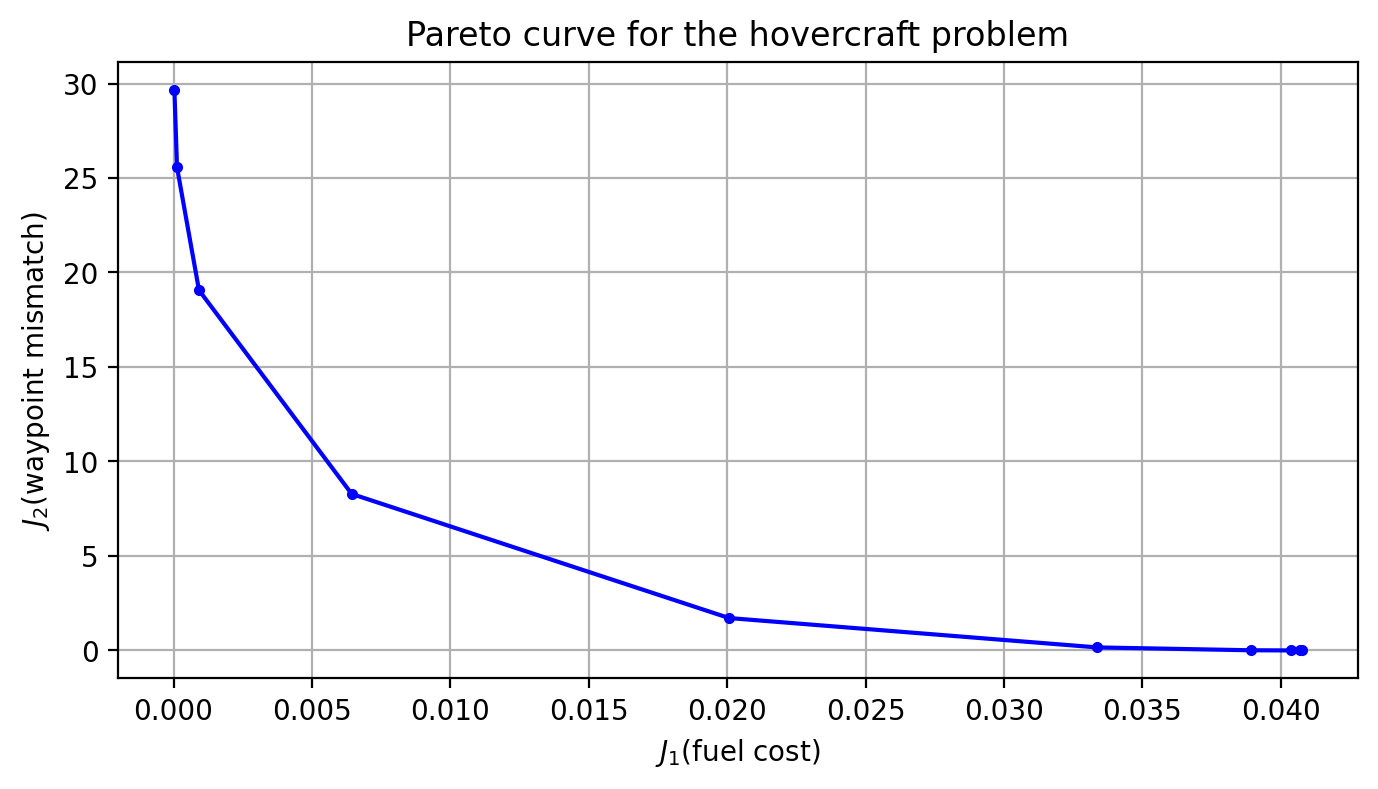

In [7]:
Npts = 10
iter = np.logspace(-5,1,Npts)
#display(iter)
sol1 = []
sol2 = []
lamTO = m['lamTO']

for lamval in iter:
    lamTO.setRecords(lamval)
    # to fix bug in interface
    lamTO.modified = True
    gams.gams(runit)
    model_status = m['model_status'].toValue()
    if model_status > 2:
        print(model_status)
        sol1.append('NaN')
        sol2.append('NaN')
        break
    else:
        J1=m['J1'].toValue()
        J2=m['J2'].toValue()
        sol1.append(J1)
        sol2.append(J2)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot( sol1, sol2, "b.-" )
ax.set_xlabel("$J_1$(fuel cost)")
ax.set_ylabel("$J_2$(waypoint mismatch)")
ax.set_title("Pareto curve for the hovercraft problem")
ax.grid();

In [8]:
%gams_cleanup --closedown